<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [ ]:
from google.colab import drive, files

In [3]:
import os
import sys

In [4]:
is_colab = 'google.colab' in sys.modules

if is_colab:
    base_path = "/content/drive/.shortcut-targets-by-id/1hNB4s6RR7JeKfFdGwm27WrF6pNXXIg3R/Deep Learning"
    drive.mount('/content/drive')

    os.chdir('/content/drive/MyDrive/Deep Learning')
    print("Changed directory to:", os.getcwd())
    !pip install keras_cv
    !pip install -q -U keras-tuner
else:
    base_path = ".."

Mounted at /content/drive
Changed directory to: /content/drive/.shortcut-targets-by-id/1hNB4s6RR7JeKfFdGwm27WrF6pNXXIg3R/Deep Learning
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.1 MB/s eta 0:00:00


## 1.2 Import Libraries

In [52]:
from classes import *
from functions import *

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import zipfile
import pickle
from pathlib import Path

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# keras
from keras_tuner import Hyperband, Objective
from tensorflow import keras
from keras import regularizers

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
# tensorflow - layers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten, BatchNormalization, Activation,
    ReLU, LeakyReLU, Add, Concatenate, concatenate)


## 1.3 Import Dataset

In [7]:
#Load the DataFrames from the .pkl files
with open(os.path.join(base_path,"data/train_df.pkl"), "rb") as f:
     train_df = pickle.load(f)

with open(os.path.join(base_path,"data/valid_df.pkl"), "rb") as f:
     val_df = pickle.load(f)

with open(os.path.join(base_path,"data/test_df.pkl"), "rb") as f:
     test_df = pickle.load(f)

with open(os.path.join(base_path,"data/train_df_sampled.pkl"), "rb") as f:
     train_df_sampled = pickle.load(f)

# with open("../data/family_encoder.pkl", "rb") as f:
#     family_encoder = pickle.load(f)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [8]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [9]:
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment=None, oversampling=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=None, oversampling=True)
# val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
# test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

In [10]:
# num_images = 32 ##
# # rows, cols = 8, 4 ##

# plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

<div class="alert alert-block alert-success">

# **3.** Parameters

<div>

In [11]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    , EarlyStopping(patience=7, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [12]:
augmentations_to_test = [
    "none",
    "medium",
#    "light",
    "mixup",
#    "heavy",
    "grayscale_plus",
#    "randaugment",
#    "color_lightening",
#    "geometric_transformations"
    ]

In [13]:
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

<div class="alert alert-block alert-success">

# **4.** Models

<div>

## 4.1 Architectures

### 4.1.1 Convolutional Baseline

In [15]:
def build_baseline(input_shape=(224, 224, 3), num_classes=202):
  # by calling Sequential:
  model = Sequential(
      layers = [
          Input(shape=input_shape),
          Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dropout(0.5),
          Dense(num_classes, activation="softmax"),
      ]
  )
  return model

model = build_baseline()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 48)   │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │    28,273,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,284,826 (107.90 MB)

 Trainable params: 28,284,826 (107.90 MB)

 Non-trainable params: 0 (0.00 B)

### 4.1.2 GoogLeNet

Uses Inception modules to capture multi-scale features

- Good balance of depth and efficiency.
- Excellent at capturing fine-grained details (your dataset has many classes with subtle visual differences).
- Faster to train than ResNet or Transformers.

GoogleNet/Inception is a large model designed to be trained on millions of images (e.g. ImageNet’s 1.2 M). With only a few dozen examples per class it simply can’t learn good feature filters from scratch. Result: the loss barely moves, accuracy plateaus just above random chance (~0.5%) because it “sees” too few unique examples to carve out 202 decision boundaries.

In [36]:
def conv_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same', weight_decay=1e-4):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False,
        kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def inception_module(x, f1, f3_in, f3_out, f5_in, f5_out, pool_proj):
#    path1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    path1 = conv_bn_relu(x, f1, (1, 1))

#    path2 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
#    path2 = Conv2D(f3_out, (3, 3), padding='same', activation='relu')(path2)
    path2 = conv_bn_relu(x, f3_in, (1, 1))
    path2 = conv_bn_relu(path2, f3_out, (3, 3))

#    path3 = Conv2D(f5_in, (1, 1), padding='same', activation='relu')(x)
#    path3 = Conv2D(f5_out, (5, 5), padding='same', activation='relu')(path3)
    path3 = conv_bn_relu(x, f5_in, (1, 1))
    path3 = conv_bn_relu(path3, f5_out, (5, 5))

#    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
#    path4 = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(path4)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = conv_bn_relu(path4, pool_proj, (1, 1))

    return concatenate([path1, path2, path3, path4], axis=-1)


def build_googlenet(input_shape=(224, 224, 3), num_classes=202, dropout_rate=0.5):
    input_layer = Input(shape=input_shape)

#    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = conv_bn_relu(input_layer, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
#    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = conv_bn_relu(x, 64, (1, 1))
    x = conv_bn_relu(x, 192, (3, 3))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
#    x = Dropout(dropout_rate)(x)
#    x = Flatten()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x) # Dropout after GlobalAveragePooling2D is critical when you remove Flatten — otherwise, the model becomes too confident and overfits fast.
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-4))(x)

    return Model(input_layer, x)

model = build_googlenet()

model.summary()


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_828 (Conv2D) │ (None, 112, 112,  │      9,408 │ input_layer_19[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_828[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_570      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_187   │ (None, 56, 56,    │          0 │ activation_570[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_829 (Conv2D) │ (None, 56, 56,    │      4,096 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_829[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_571      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_830 (Conv2D) │ (None, 56, 56,    │    110,592 │ activation_571[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_830[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_572      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_188   │ (None, 28, 28,    │          0 │ activation_572[0… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_832 (Conv2D) │ (None, 28, 28,    │     18,432 │ max_pooling2d_18… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_834 (Conv2D) │ (None, 28, 28,    │      3,072 │ max_pooling2d_18… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_832[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_834[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_574      │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 6,202,442 (23.66 MB)

 Trainable params: 6,187,882 (23.60 MB)

 Non-trainable params: 14,560 (56.88 KB)

### 4.1.3 VGGNet

inspired by VGG16 — a deep and uniform architecture with 3x3 convolutions and max pooling.

In [17]:
def build_vgg_model(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 4 (optional to reduce overfitting)
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_vgg_model()

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,601,866 (399.02 MB)

 Trainable params: 104,600,970 (399.02 MB)

 Non-trainable params: 896 (3.50 KB)

### 4.1.4 ResNet

In [18]:
def residual_block(x, filters, stride=1, downsample=False, l2_weight=1e-4):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)

    # Downsample the shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=202,
                   num_blocks=[2, 2, 2, 2],
                   dropout_rate=0.5, l2_weight=1e-4, head_units=128, head_activation="relu"):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(l2_weight))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filter_sizes = [64, 128, 256, 512]
    for stage, (filters, blocks) in enumerate(zip(filter_sizes, num_blocks)):
        for block in range(blocks):
            stride = 2 if block == 0 and stage > 0 else 1
            downsample = True if block == 0 and stage > 0 else False
            x = residual_block(x, filters, stride=stride, downsample=downsample, l2_weight=l2_weight)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(head_units, kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    if head_activation == "leaky_relu":
        x = LeakyReLU()(x)
    else:
        x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

### 4.1.5 DenseNet

In [19]:
def dense_layer(x, growth_rate):
    """Single layer inside a dense block."""
    out = BatchNormalization()(x)
    out = ReLU()(out)
    out = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(out)
    x = Concatenate()([x, out])  # Concatenate input and output (dense connection)
    return x

def dense_block(x, num_layers, growth_rate):
    """Dense block with several dense layers."""
    for _ in range(num_layers):
        x = dense_layer(x, growth_rate)
    return x

def transition_layer(x, reduction=0.5):
    """Reduces spatial size and number of filters."""
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x

def build_densenet(input_shape=(224, 224, 3), num_classes=202, growth_rate=32):
    inputs = Input(shape=input_shape)

    # Initial conv
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Block 1
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 2
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 3
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 4
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)

    # Classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_densenet()

model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ average_pooling2… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 56, 56,    │     18,464 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 56, 56,    │          0 │ average_pooling2… │
│ (Concatenate)       │ 96)               │            │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate_9[0]… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 56, 56,    │     27,680 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 56, 56,    │          0 │ concatenate_9[0]… │
│ (Concatenate)       │ 128)              │            │ conv2d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_10[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 56, 56,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 56, 56,    │          0 │ concatenate_10[0

 Total params: 817,922 (3.12 MB)

 Trainable params: 811,810 (3.10 MB)

 Non-trainable params: 6,112 (23.88 KB)

## 4.2 Initial model assessment

In [16]:
# Define your architectures (you already have build_resnet18)
model_builders = {
    "baseline": build_baseline,
    "googlenet": build_googlenet,
    "vgg_model": build_vgg_model,
    "resnet": build_resnet18,
    "dense_net": build_densenet
}

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
  print(f"\nTraining architecture: {arch_name} with no augmentation")

  # Build model
  model = build_fn()

  # Compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=metrics
  )

  # Load datasets
  train_ds, class_names = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/train"),
      minority_class=minority_class,
      augment=None,
      oversampling=True,
      shuffle=True
  )

  val_ds, _ = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/val"),
      minority_class=minority_class,
      augment=None,
      oversampling=False
  )

  # Initialize experiment
  experiment = Experiment(
      model=model,
      train_ds=train_ds,
      val_ds=val_ds,
      experiment_name=f"{arch_name}",
      batch_size=batch_size,
      image_size=image_size,
      save_model=False
  )

  # Run training
  history = experiment.run_experiment(callbacks=[], epochs=20)

  # Predict on validation set
  preds = model.predict(val_ds)
  y_pred = np.argmax(preds, axis=1)
  y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

  # Compute custom metrics
  f1_macro = f1_score(y_true, y_pred, average='macro')
  f1_weighted = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')

  # Evaluate model using Keras metrics
  train_eval = model.evaluate(train_ds, verbose=0)
  val_eval = model.evaluate(val_ds, verbose=0)

  metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
  train_metrics = dict(zip(metric_names, train_eval))
  val_metrics = dict(zip(metric_names, val_eval))

  # Append results
  all_results.append({
      "architecture": arch_name,

      "train_loss": train_metrics["loss"],
      "val_loss": val_metrics["loss"],

      "train_accuracy": train_metrics["accuracy"],
      "val_accuracy": val_metrics["accuracy"],

      "train_f1_macro": train_metrics["f1_macro"],
      "val_f1_macro": val_metrics["f1_macro"],
      "val_f1_weighted": val_metrics["f1_weighted"],
      "val_precision": precision,
      "val_recall": recall
  })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)
display(results_df.round(4))



Training architecture: baseline with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.0423 - auc: 0.6249 - f1_macro: 0.0064 - f1_weighted: 0.0149 - loss: 5.3833 - top5_accuracy: 0.1245 - val_accuracy: 0.0957 - val_auc: 0.7510 - val_f1_macro: 0.0290 - val_f1_weighted: 0.0519 - val_loss: 4.6748 - val_top5_accuracy: 0.2376
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.1750 - auc: 0.8666 - f1_macro: 0.1401 - f1_weighted: 0.1440 - loss: 4.0011 - top5_accuracy: 0.3693 - val_accuracy: 0.1336 - val_auc: 0.7847 - val_f1_macro: 0.0875 - val_f1_weighted: 0.1088 - val_loss: 4.4241 - val_top5_accuracy: 0.2899
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4971 - auc: 0.9479 - f1_macro: 0.5206 - f1_weighted: 0.4958 - loss: 2.6312 - top5_accuracy: 0.7029 - val_accuracy: 0.1603 - val_auc: 0.7933

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 151ms/step - accuracy: 0.0651 - auc: 0.6011 - f1_macro: 0.0506 - f1_weighted: 0.0607 - loss: 5.2625 - top5_accuracy: 0.1543 - val_accuracy: 0.0239 - val_auc: 0.6493 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0869 - val_top5_accuracy: 0.1185
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.0208 - auc: 0.5979 - f1_macro: 0.0013 - f1_weighted: 0.0048 - loss: 5.1874 - top5_accuracy: 0.0937 - val_accuracy: 0.0417 - val_auc: 0.6625 - val_f1_macro: 0.0014 - val_f1_weighted: 0.0070 - val_loss: 5.0149 - val_top5_accuracy: 0.1380
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.0275 - auc: 0.6124 - f1_macro: 0.0019 - f1_weighted: 0.0064 - loss: 5.1409 - top5_accuracy: 0.1050 - val_accuracy: 0.0373 - val_auc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: vgg_model with no augmentation


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 178s 406ms/step - accuracy: 0.0525 - auc: 0.6046 - f1_macro: 0.0228 - f1_weighted: 0.0401 - loss: 6.2733 - top5_accuracy: 0.1333 - val_accuracy: 0.0234 - val_auc: 0.5265 - val_f1_macro: 0.0033 - val_f1_weighted: 0.0059 - val_loss: 5.5061 - val_top5_accuracy: 0.0757
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 362ms/step - accuracy: 0.0176 - auc: 0.5596 - f1_macro: 0.0042 - f1_weighted: 0.0084 - loss: 5.4965 - top5_accuracy: 0.0848 - val_accuracy: 0.0211 - val_auc: 0.6054 - val_f1_macro: 0.0032 - val_f1_weighted: 0.0045 - val_loss: 5.4798 - val_top5_accuracy: 0.1169
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 362ms/step - accuracy: 0.0257 - auc: 0.5798 - f1_macro: 0.0103 - f1_weighted: 0.0165 - loss: 5.4885 - top5_accuracy: 0.0903 - val_accuracy: 0.0356 - val_auc: 0.5899 - val_f1_macro: 0.0049 - val_f1_weighted: 0.0107

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 155ms/step - accuracy: 0.0570 - auc: 0.6020 - f1_macro: 0.0344 - f1_weighted: 0.0542 - loss: 5.9634 - top5_accuracy: 0.1171 - val_accuracy: 0.0284 - val_auc: 0.5564 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0062 - val_loss: 5.7855 - val_top5_accuracy: 0.0740
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.0321 - auc: 0.5916 - f1_macro: 0.0096 - f1_weighted: 0.0195 - loss: 5.6783 - top5_accuracy: 0.0849 - val_accuracy: 0.0762 - val_auc: 0.6755 - val_f1_macro: 0.0081 - val_f1_weighted: 0.0286 - val_loss: 5.3590 - val_top5_accuracy: 0.1859
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.0417 - auc: 0.6256 - f1_macro: 0.0107 - f1_weighted: 0.0220 - loss: 5.5626 - top5_accuracy: 0.1078 - val_accuracy: 0.0796 - val_auc: 0.6934

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: dense_net with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 89s 151ms/step - accuracy: 0.0540 - auc: 0.6336 - f1_macro: 0.0157 - f1_weighted: 0.0327 - loss: 5.4768 - top5_accuracy: 0.1430 - val_accuracy: 0.0295 - val_auc: 0.5984 - val_f1_macro: 0.0020 - val_f1_weighted: 0.0092 - val_loss: 5.3211 - val_top5_accuracy: 0.0946
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0561 - auc: 0.6477 - f1_macro: 0.0103 - f1_weighted: 0.0249 - loss: 5.1665 - top5_accuracy: 0.1428 - val_accuracy: 0.0785 - val_auc: 0.6950 - val_f1_macro: 0.0144 - val_f1_weighted: 0.0367 - val_loss: 5.0054 - val_top5_accuracy: 0.1853
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0671 - auc: 0.6908 - f1_macro: 0.0167 - f1_weighted: 0.0332 - loss: 4.9983 - top5_accuracy: 0.1751 - val_accuracy: 0.0874 - val_auc: 0.717

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,architecture,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,baseline,0.0289,8.4305,0.9921,0.1697,0.9974,0.1326,0.1676,0.2401,0.1697
1,vgg_model,1.0658,5.0694,0.8401,0.1575,0.8509,0.0978,0.1302,0.1490,0.1575
2,dense_net,4.3609,4.7914,0.1454,0.1185,0.0891,0.0573,0.0851,0.0951,0.1185
3,googlenet,4.0019,4.3110,0.1400,0.1297,0.0657,0.0492,0.0899,0.0892,0.1297
4,resnet,4.5899,4.7907,0.1333,0.1085,0.0567,0.0362,0.0682,0.0832,0.1085


## 4.3 GoogLe Net

### 4.3.1 First run - basic model

In [22]:
model = build_googlenet()
model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
          metrics=metrics
      )
# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="mixup",
    oversampling=True,
    shuffle=True
)


val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_basic",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

# Run training
history = experiment.run_experiment(callbacks=callbacks, epochs=100)

# Predict on validation set
preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# Compute custom metrics
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Evaluate model using Keras metrics
train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

# Append results
all_results.append({
    "train_loss": train_metrics["loss"],
    "val_loss": val_metrics["loss"],

    "train_accuracy": train_metrics["accuracy"],
    "val_accuracy": val_metrics["accuracy"],

    "train_f1_macro": train_metrics["f1_macro"],
    "val_f1_macro": f1_macro,
    "val_f1_weighted": f1_weighted,
    "val_precision": precision,
    "val_recall": recall
})

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
display(results_df.round(4))


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - accuracy: 0.0614 - auc: 0.6136 - f1_macro: 0.0362 - f1_weighted: 0.0512 - loss: 5.2596 - top5_accuracy: 0.1563 - val_accuracy: 0.0223 - val_auc: 0.6442 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0657 - val_top5_accuracy: 0.1185 - learning_rate: 1.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.0179 - auc: 0.5899 - f1_macro: 0.0010 - f1_weighted: 0.0039 - loss: 5.2088 - top5_accuracy: 0.0908 - val_accuracy: 0.0284 - val_auc: 0.6502 - val_f1_macro: 5.2734e-04 - val_f1_weighted: 0.0027 - val_loss: 5.0594 - val_top5_accuracy: 0.1185 - learning_rate: 1.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0156 - auc: 0.5933 - f1_macro: 9.4291e-04 - f1_weighted: 0.0036 - loss: 5.2010 - top5_accuracy: 0.0915 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,3.2043,3.9341,0.4379,0.2092,0.3435,0.1359,0.1811,0.1924,0.2092


### 4.3.2 Second run

1. flatten -> globalaveragepooling
2. added batch norm after each convolutional layer for better convergence -> when using batch norm, the rule of thumb say we should use dropout 0.2-0.3
3. added regularizers

In [33]:
# Extract true labels from train_ds
y_train = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in train_ds])

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create dictionary {class_idx: weight}
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

In [41]:
model = build_googlenet(dropout_rate=0.3)
model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
          metrics=metrics
      )
# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
results_2 = []

# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="mixup",
    oversampling=True,
    shuffle=True
)


val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_basic",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

# Run training
history = experiment.run_experiment(callbacks=callbacks, epochs=100)

# Predict on validation set
preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# Compute custom metrics
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Evaluate model using Keras metrics
train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

# Append results
results_2.append({
    "train_loss": train_metrics["loss"],
    "val_loss": val_metrics["loss"],

    "train_accuracy": train_metrics["accuracy"],
    "val_accuracy": val_metrics["accuracy"],

    "train_f1_macro": train_metrics["f1_macro"],
    "val_f1_macro": f1_macro,
    "val_f1_weighted": f1_weighted,
    "val_precision": precision,
    "val_recall": recall
})

# Convert results to DataFrame
results_df_2 = pd.DataFrame(results_2)
display(results_df_2.round(4))


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 124s 181ms/step - accuracy: 0.1269 - auc: 0.6304 - f1_macro: 0.0964 - f1_weighted: 0.1012 - loss: 6.3236 - top5_accuracy: 0.3157 - val_accuracy: 0.0189 - val_auc: 0.5819 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0055 - val_loss: 13.5647 - val_top5_accuracy: 0.0913 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.0393 - auc: 0.6151 - f1_macro: 0.0034 - f1_weighted: 0.0111 - loss: 5.8963 - top5_accuracy: 0.1263 - val_accuracy: 0.0451 - val_auc: 0.6244 - val_f1_macro: 0.0037 - val_f1_weighted: 0.0161 - val_loss: 21.0930 - val_top5_accuracy: 0.1564 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.0477 - auc: 0.6318 - f1_macro: 0.0035 - f1_weighted: 0.0120 - loss: 5.6708 - top5_accuracy: 0.1389 - val_accuracy: 0.0668 - val_auc: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,4.9207,4.7935,0.0941,0.0985,0.029,0.0308,0.0598,0.0571,0.0985


## ResnET

### 4.6.1 Defining default architectures

In [44]:
def residual_block(x, filters, stride=1, downsample=False, l2_weight=1e-4):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)

    # Downsample the shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=202,
                   num_blocks=[2, 2, 2, 2],
                   dropout_rate=0.6, l2_weight=1e-4, head_units=128, head_activation="relu"):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(l2_weight))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filter_sizes = [64, 128, 256, 512]
    for stage, (filters, blocks) in enumerate(zip(filter_sizes, num_blocks)):
        for block in range(blocks):
            stride = 2 if block == 0 and stage > 0 else 1
            downsample = True if block == 0 and stage > 0 else False
            x = residual_block(x, filters, stride=stride, downsample=downsample, l2_weight=l2_weight)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(head_units, kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    if head_activation == "leaky_relu":
        x = LeakyReLU()(x)
    else:
        x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)


model = build_resnet18()

model.summary()


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1196         │ (None, 112, 112,  │      9,472 │ input_layer_27[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1196[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_42 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_267   │ (None, 56, 56,    │          0 │ re_lu_42[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1197         │ (None, 56, 56,    │     36,928 │ max_pooling2d_26… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1197[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_43 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1198         │ (None, 56, 56,    │     36,928 │ re_lu_43[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1198[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 56, 56,    │          0 │ add_9[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1199         │ (None, 56, 56,    │     36,928 │ re_lu_44[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1199[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1200         │ (None, 56, 56,    │     36,928 │ re_lu_45[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1200[0][0

 Total params: 11,283,146 (43.04 MB)

 Trainable params: 11,273,290 (43.00 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [45]:
def bottleneck_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # 1x1 Conv (reduce dimensions)
    x = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3x3 Conv
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 1x1 Conv (restore dimensions)
    x = Conv2D(filters * 4, (1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters * 4, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet50(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv2_x
    for _ in range(3):
        x = bottleneck_block(x, 64, downsample=(_ == 0))

    # Conv3_x
    for _ in range(4):
        x = bottleneck_block(x, 128, stride=2 if _ == 0 else 1, downsample=(_ == 0))

    # Conv4_x
    for _ in range(6):
        x = bottleneck_block(x, 256, stride=2 if _ == 0 else 1, downsample=(_ == 0))

    # Conv5_x
    for _ in range(3):
        x = bottleneck_block(x, 512, stride=2 if _ == 0 else 1, downsample=(_ == 0))

    x = Dropout(0.6)(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_resnet50()

model.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1216         │ (None, 112, 112,  │      9,472 │ input_layer_28[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1216[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_60 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_268   │ (None, 56, 56,    │          0 │ re_lu_60[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1217         │ (None, 56, 56,    │      4,160 │ max_pooling2d_26… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1217[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_61 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1218         │ (None, 56, 56,    │     36,928 │ re_lu_61[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1218[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_62 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1219         │ (None, 56, 56,    │     16,640 │ re_lu_62[0][0]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1220         │ (None, 56, 56,    │     16,640 │ max_pooling2d_26… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_1219[0][0] │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_1220[0][0] │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_63 (ReLU)     │ (None, 56, 56,    │          0 │ add_17[0][0]    

 Total params: 24,001,610 (91.56 MB)

 Trainable params: 23,948,490 (91.36 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [46]:
def wide_basic_block(x, filters, stride=1, downsample=False, widen_factor=4, l2_weight=1e-4):
    shortcut = x
    out_filters = filters * widen_factor  # final number of output channels

    # First conv
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(out_filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(x)

    # Second conv
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(out_filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(l2_weight))(x)

    # Adjust shortcut if needed
    if downsample or shortcut.shape[-1] != out_filters:
        shortcut = Conv2D(out_filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(shortcut)

    x = Add()([x, shortcut])
    return x


def build_wideresnet28_4(input_shape=(224, 224, 3),
                         num_classes=202,
                         widen_factor=4,
                         dropout_rate=0.6,
                         l2_weight=1e-4,
                         num_blocks=4,
                         head_units=256,
                         head_activation="relu"):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (3, 3), strides=1, padding='same', kernel_regularizer=l2(l2_weight))(inputs)

    for i in range(num_blocks):
        x = wide_basic_block(x, 16, stride=1 if i > 0 else 1, downsample=(i == 0),
                             widen_factor=widen_factor, l2_weight=l2_weight)

    for i in range(num_blocks):
        x = wide_basic_block(x, 32, stride=1 if i > 0 else 2, downsample=(i == 0),
                             widen_factor=widen_factor, l2_weight=l2_weight)

    for i in range(num_blocks):
        x = wide_basic_block(x, 64, stride=1 if i > 0 else 2, downsample=(i == 0),
                             widen_factor=widen_factor, l2_weight=l2_weight)

    x = GlobalAveragePooling2D()(x)
    x = Dense(head_units, kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)

    if head_activation == "leaky_relu":
        x = LeakyReLU()(x)
    else:
        x = ReLU()(x)

    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)


model = build_wideresnet28_4()

model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1269         │ (None, 224, 224,  │        448 │ input_layer_29[0… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_1269[0][0] │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_109 (ReLU)    │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1270         │ (None, 224, 224,  │      9,280 │ re_lu_109[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1270[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_110 (ReLU)    │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1271         │ (None, 224, 224,  │     36,928 │ re_lu_110[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1272         │ (None, 224, 224,  │      1,088 │ conv2d_1269[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 224, 224,  │          0 │ conv2d_1271[0][0… │
│                     │ 64)               │            │ conv2d_1272[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ add_33[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_111 (ReLU)    │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1273         │ (None, 224, 224,  │     36,928 │ re_lu_111[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1273[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_112 (ReLU)    │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1274         │ (None, 224, 224,  │     36,928 │ re_lu_112[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 224, 224,  │          0 │ conv2d_1274[0][0

 Total params: 5,975,434 (22.79 MB)

 Trainable params: 5,968,234 (22.77 MB)

 Non-trainable params: 7,200 (28.12 KB)

In [47]:
def resnext_block(x, filters, stride=1, groups=32, downsample=False):
    shortcut = x
    grouped_channels = filters // 2  # e.g., 128 for ResNeXt-50

    # 1x1 Conv (reduce dimensions)
    x = Conv2D(grouped_channels, (1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3x3 Grouped Conv
    x = Conv2D(grouped_channels, (3, 3), strides=stride, padding='same', groups=groups, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 1x1 Conv (restore dimensions)
    x = Conv2D(filters * 4, (1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnext50(input_shape=(224, 224, 3), num_classes=202, groups=32):
    inputs = Input(shape=input_shape)

    # Initial Conv + MaxPool
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv2_x: 3 blocks
    for i in range(3):
        x = resnext_block(x, filters=128, stride=1, groups=groups, downsample=(i == 0))

    # Conv3_x: 4 blocks
    for i in range(4):
        x = resnext_block(x, filters=256, stride=2 if i == 0 else 1, groups=groups, downsample=(i == 0))

    # Conv4_x: 6 blocks
    for i in range(6):
        x = resnext_block(x, filters=512, stride=2 if i == 0 else 1, groups=groups, downsample=(i == 0))

    # Conv5_x: 3 blocks
    for i in range(3):
        x = resnext_block(x, filters=1024, stride=2 if i == 0 else 1, groups=groups, downsample=(i == 0))

    # Dropout and Head
    x = Dropout(0.6)(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_resnext50()

model.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1297         │ (None, 112, 112,  │      9,472 │ input_layer_30[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1297[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_134 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_269   │ (None, 56, 56,    │          0 │ re_lu_134[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1298         │ (None, 56, 56,    │      4,160 │ max_pooling2d_26… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1298[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_135 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1299         │ (None, 56, 56,    │      1,216 │ re_lu_135[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1299[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_136 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1300         │ (None, 56, 56,    │     33,280 │ re_lu_136[0][0]   │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1301         │ (None, 56, 56,    │     33,280 │ max_pooling2d_26… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      2,048 │ conv2d_1300[0][0] │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      2,048 │ conv2d_1301[0][0] │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_137 (ReLU)    │ (None, 56, 56,    │          0 │ add_45[0][0]    

 Total params: 31,175,626 (118.93 MB)

 Trainable params: 31,084,618 (118.58 MB)

 Non-trainable params: 91,008 (355.50 KB)

### 4.6.2 Testing augmentations

In [ ]:
# Define your architectures (you already have build_resnet18)
model_builders = {
    "resnet18": build_resnet18
}

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
    for aug in augmentations_to_test:
        print(f"\nTraining architecture: {arch_name} with augmentation: {aug}")

        # Build model
        model = build_fn()

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
            metrics=metrics
        )

        # Load datasets
        train_ds, class_names = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/train"),
            minority_class=minority_class,
            augment=aug,
            oversampling=True,
            shuffle=True
        )

        if aug == "grayscale_plus":
            val_ds, _ = preprocess.load_img(
                data_dir=os.path.join(base_path, "data/rare_species/val"),
                minority_class=minority_class,
                augment=aug,
                oversampling=False
            )
        else:
            val_ds, _ = preprocess.load_img(
                data_dir=os.path.join(base_path, "data/rare_species/val"),
                minority_class=minority_class,
                augment=None,
                oversampling=False
            )

        # Initialize experiment
        experiment = Experiment(
            model=model,
            train_ds=train_ds,
            val_ds=val_ds,
            experiment_name=f"{arch_name}_with_{aug}",
            batch_size=batch_size,
            image_size=image_size,
            save_model=False
        )

        # Run training
        history = experiment.run_experiment(callbacks=callbacks, epochs=30)

        # Predict on validation set
        preds = model.predict(val_ds)
        y_pred = np.argmax(preds, axis=1)
        y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

        # Compute custom metrics
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

        # Evaluate model using Keras metrics
        train_eval = model.evaluate(train_ds, verbose=0)
        val_eval = model.evaluate(val_ds, verbose=0)

        metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
        train_metrics = dict(zip(metric_names, train_eval))
        val_metrics = dict(zip(metric_names, val_eval))

        # Append results
        all_results.append({
            "architecture": arch_name,
            "augmentation": aug,

            "train_loss": train_metrics["loss"],
            "val_loss": val_metrics["loss"],

            "train_accuracy": train_metrics["accuracy"],
            "val_accuracy": val_metrics["accuracy"],

            "val_f1_macro": f1_macro,
            "val_f1_weighted": f1_weighted,
            "val_precision": precision,
            "val_recall": recall
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
display(results_df.round(4))



Training architecture: resnet18 with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 61s 93ms/step - accuracy: 0.0335 - auc: 0.5781 - f1_macro: 0.0163 - f1_weighted: 0.0293 - loss: 6.1780 - top5_accuracy: 0.0885 - val_accuracy: 0.0312 - val_auc: 0.5803 - val_f1_macro: 0.0012 - val_f1_weighted: 0.0043 - val_loss: 5.6752 - val_top5_accuracy: 0.0979 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0426 - auc: 0.6136 - f1_macro: 0.0104 - f1_weighted: 0.0218 - loss: 5.6978 - top5_accuracy: 0.1056 - val_accuracy: 0.0440 - val_auc: 0.6510 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0223 - val_loss: 5.6422 - val_top5_accuracy: 0.1436 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0546 - auc: 0.6510 - f1_macro: 0.0154 - f1_weighted: 0.0281 - loss: 5.5003 - top5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: medium
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.0719 - auc: 0.6209 - f1_macro: 0.0475 - f1_weighted: 0.0715 - loss: 6.1404 - top5_accuracy: 0.1438 - val_accuracy: 0.0306 - val_auc: 0.5644 - val_f1_macro: 0.0021 - val_f1_weighted: 0.0090 - val_loss: 5.7797 - val_top5_accuracy: 0.0785 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0470 - auc: 0.6115 - f1_macro: 0.0105 - f1_weighted: 0.0247 - loss: 5.6764 - top5_accuracy: 0.1100 - val_accuracy: 0.0762 - val_auc: 0.6831 - val_f1_macro: 0.0079 - val_f1_weighted: 0.0302 - val_loss: 5.3587 - val_top5_accuracy: 0.1925 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0570 - auc: 0.6468 - f1_macro: 0.0132 - f1_weighted: 0.0280 - loss: 5.5027 - t

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: light
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 76s 137ms/step - accuracy: 0.0518 - auc: 0.6205 - f1_macro: 0.0187 - f1_weighted: 0.0398 - loss: 6.1808 - top5_accuracy: 0.1308 - val_accuracy: 0.0323 - val_auc: 0.5985 - val_f1_macro: 0.0014 - val_f1_weighted: 0.0058 - val_loss: 5.6504 - val_top5_accuracy: 0.0896 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0443 - auc: 0.6074 - f1_macro: 0.0120 - f1_weighted: 0.0258 - loss: 5.7234 - top5_accuracy: 0.1073 - val_accuracy: 0.0746 - val_auc: 0.6674 - val_f1_macro: 0.0104 - val_f1_weighted: 0.0339 - val_loss: 6.4401 - val_top5_accuracy: 0.1881 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.0591 - auc: 0.6461 - f1_macro: 0.0161 - f1_weighted: 0.0328 - loss: 5.5337 - to

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - accuracy: 0.0194 - auc: 0.5402 - f1_macro: 0.0052 - f1_weighted: 0.0107 - loss: 6.1584 - top5_accuracy: 0.0589 - val_accuracy: 0.0378 - val_auc: 0.5853 - val_f1_macro: 0.0030 - val_f1_weighted: 0.0128 - val_loss: 5.6308 - val_top5_accuracy: 0.0991 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0388 - auc: 0.5770 - f1_macro: 0.0083 - f1_weighted: 0.0182 - loss: 5.7615 - top5_accuracy: 0.1034 - val_accuracy: 0.0690 - val_auc: 0.7012 - val_f1_macro: 0.0063 - val_f1_weighted: 0.0242 - val_loss: 5.3662 - val_top5_accuracy: 0.1970 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0499 - auc: 0.6012 - f1_macro: 0.0089 - f1_weighted: 0.0210 - loss: 5.6112 - top

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: heavy
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.0627 - auc: 0.6228 - f1_macro: 0.0355 - f1_weighted: 0.0544 - loss: 6.1103 - top5_accuracy: 0.1362 - val_accuracy: 0.0317 - val_auc: 0.5715 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0069 - val_loss: 5.6822 - val_top5_accuracy: 0.1046 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0379 - auc: 0.6066 - f1_macro: 0.0083 - f1_weighted: 0.0195 - loss: 5.7166 - top5_accuracy: 0.1031 - val_accuracy: 0.0618 - val_auc: 0.6917 - val_f1_macro: 0.0062 - val_f1_weighted: 0.0250 - val_loss: 5.3997 - val_top5_accuracy: 0.1820 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0455 - auc: 0.6312 - f1_macro: 0.0100 - f1_weighted: 0.0217 - loss: 5.5709 - to

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: grayscale_plus
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 139ms/step - accuracy: 0.0560 - auc: 0.6269 - f1_macro: 0.0271 - f1_weighted: 0.0458 - loss: 6.1472 - top5_accuracy: 0.1387 - val_accuracy: 0.0250 - val_auc: 0.5722 - val_f1_macro: 0.0012 - val_f1_weighted: 0.0058 - val_loss: 5.8031 - val_top5_accuracy: 0.0924 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0319 - auc: 0.5936 - f1_macro: 0.0070 - f1_weighted: 0.0157 - loss: 5.7600 - top5_accuracy: 0.0881 - val_accuracy: 0.0618 - val_auc: 0.6772 - val_f1_macro: 0.0050 - val_f1_weighted: 0.0196 - val_loss: 5.4015 - val_top5_accuracy: 0.1558 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0410 - auc: 0.6216 - f1_macro: 0.0095 - f1_weighted: 0.0201 - loss: 5.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: randaugment
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 76s 131ms/step - accuracy: 0.0444 - auc: 0.6019 - f1_macro: 0.0199 - f1_weighted: 0.0377 - loss: 6.2042 - top5_accuracy: 0.1070 - val_accuracy: 0.0211 - val_auc: 0.5864 - val_f1_macro: 3.0077e-04 - val_f1_weighted: 0.0014 - val_loss: 5.6555 - val_top5_accuracy: 0.0979 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0242 - auc: 0.5692 - f1_macro: 0.0048 - f1_weighted: 0.0118 - loss: 5.9009 - top5_accuracy: 0.0719 - val_accuracy: 0.0707 - val_auc: 0.6605 - val_f1_macro: 0.0051 - val_f1_weighted: 0.0190 - val_loss: 5.4383 - val_top5_accuracy: 0.1614 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0280 - auc: 0.5966 - f1_macro: 0.0056 - f1_weighted: 0.0129 - loss: 5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: color_lightening
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 98ms/step - accuracy: 0.0629 - auc: 0.6237 - f1_macro: 0.0349 - f1_weighted: 0.0540 - loss: 6.1451 - top5_accuracy: 0.1407 - val_accuracy: 0.0362 - val_auc: 0.5980 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0054 - val_loss: 5.6412 - val_top5_accuracy: 0.0996 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0400 - auc: 0.6091 - f1_macro: 0.0101 - f1_weighted: 0.0218 - loss: 5.7033 - top5_accuracy: 0.1089 - val_accuracy: 0.0679 - val_auc: 0.6981 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0293 - val_loss: 5.3655 - val_top5_accuracy: 0.1970 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0551 - auc: 0.6448 - f1_macro: 0.0127 - f1_weighted: 0.0273 - loss: 5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: geometric_transformations
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - accuracy: 0.0631 - auc: 0.6215 - f1_macro: 0.0321 - f1_weighted: 0.0577 - loss: 6.1852 - top5_accuracy: 0.1346 - val_accuracy: 0.0289 - val_auc: 0.5773 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0075 - val_loss: 5.7486 - val_top5_accuracy: 0.0918 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0355 - auc: 0.5939 - f1_macro: 0.0093 - f1_weighted: 0.0199 - loss: 5.7652 - top5_accuracy: 0.0886 - val_accuracy: 0.0696 - val_auc: 0.6682 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0258 - val_loss: 5.6301 - val_top5_accuracy: 0.1781 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.0499 - auc: 0.6349 - f1_macro: 0.0114 - f1_weighted: 0.0243

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,architecture,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,resnet18,none,1.3911,4.5692,0.9362,0.1920,0.1255,0.1746,0.1920,0.1920
1,resnet18,medium,4.5955,4.7878,0.1363,0.1319,0.0420,0.0865,0.1112,0.1319
2,resnet18,light,5.7216,5.6504,0.0232,0.0323,0.0014,0.0058,0.0046,0.0323
3,resnet18,mixup,3.7449,4.7442,0.4610,0.1642,0.0930,0.1301,0.1555,0.1642
4,resnet18,heavy,3.6324,4.5743,0.2922,0.1469,0.0638,0.1057,0.0993,0.1469
5,resnet18,grayscale_plus,2.9042,4.9170,0.5308,0.1230,0.0487,0.0880,0.0835,0.1230
6,resnet18,randaugment,3.4322,4.5227,0.3413,0.1697,0.0846,0.1234,0.1138,0.1697
7,resnet18,color_lightening,3.3282,4.6069,0.3733,0.1720,0.0789,0.1344,0.1446,0.1720
8,resnet18,geometric_transformations,4.0121,4.5991,0.2145,0.1586,0.0755,0.1224,0.1463,0.1586


In [ ]:
# Sort by f1_macro descending
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)

# Display the table
display(results_df.round(4))

,architecture,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,resnet18,none,1.3911,4.5692,0.9362,0.1920,0.1255,0.1746,0.1920,0.1920
1,resnet18,mixup,3.7449,4.7442,0.4610,0.1642,0.0930,0.1301,0.1555,0.1642
2,resnet18,randaugment,3.4322,4.5227,0.3413,0.1697,0.0846,0.1234,0.1138,0.1697
3,resnet18,color_lightening,3.3282,4.6069,0.3733,0.1720,0.0789,0.1344,0.1446,0.1720
4,resnet18,geometric_transformations,4.0121,4.5991,0.2145,0.1586,0.0755,0.1224,0.1463,0.1586
5,resnet18,heavy,3.6324,4.5743,0.2922,0.1469,0.0638,0.1057,0.0993,0.1469
6,resnet18,grayscale_plus,2.9042,4.9170,0.5308,0.1230,0.0487,0.0880,0.0835,0.1230
7,resnet18,medium,4.5955,4.7878,0.1363,0.1319,0.0420,0.0865,0.1112,0.1319
8,resnet18,light,5.7216,5.6504,0.0232,0.0323,0.0014,0.0058,0.0046,0.0323


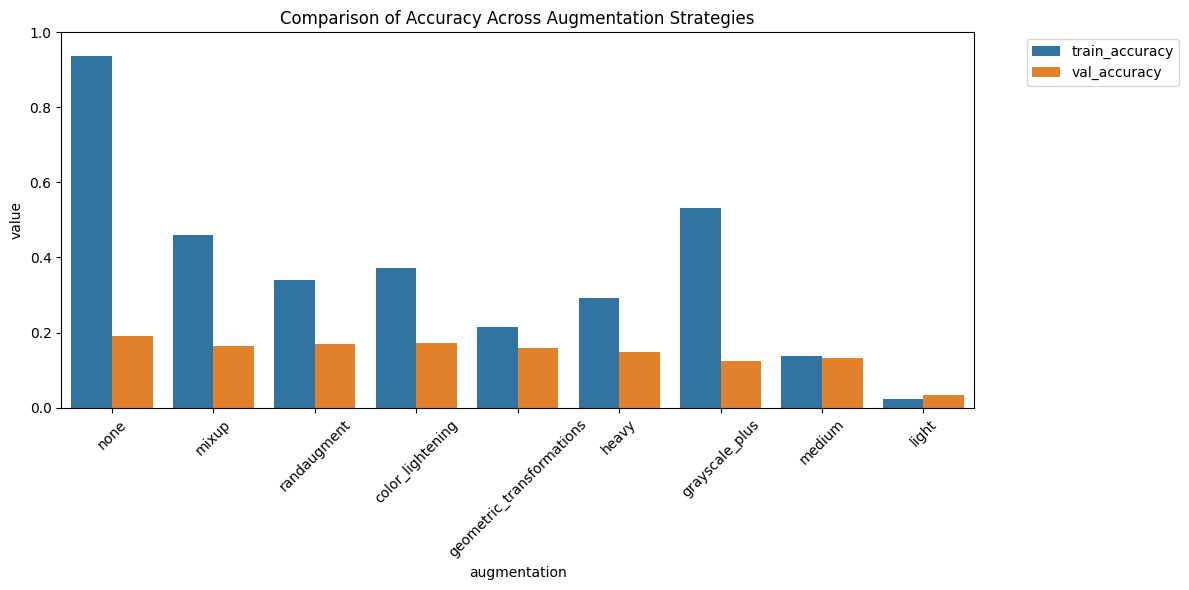

In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4.6.3 Testing default architectures

Including class weights.

In [ ]:
# Pre processing
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Define models to test
model_builders = {
    "resnet18": build_resnet18,
    "resnet50": build_resnet50,
    "wideresnet": build_wideresnet28_4,
    "resnext50": build_resnext50
}

# Store all results
all_results = []


# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
  print(f"\nTraining architecture: {arch_name}")
  model = build_fn()
  model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
            metrics=metrics
        )

  # Load datasets
  train_ds, class_names = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/train"),
      minority_class=minority_class,
      augment="mixup",
      oversampling=True,
      shuffle=True
  )


  val_ds, _ = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/val"),
      minority_class=minority_class,
      augment=None,
      oversampling=False
  )

  # Run experiment
  model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=30,
            callbacks=callbacks,
            class_weight=class_weights
        )

  # Predict on validation set
  preds = model.predict(val_ds)
  y_pred = np.argmax(preds, axis=1)
  y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

  # Compute custom metrics
  f1_macro = f1_score(y_true, y_pred, average='macro')
  f1_weighted = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')

  # Evaluate model using Keras metrics
  train_eval = model.evaluate(train_ds, verbose=0)
  val_eval = model.evaluate(val_ds, verbose=0)

  metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
  train_metrics = dict(zip(metric_names, train_eval))
  val_metrics = dict(zip(metric_names, val_eval))

  # Append results
  all_results.append({
      "architecture": arch_name,
      "augmentation": aug,

      "train_loss": train_metrics["loss"],
      "val_loss": val_metrics["loss"],

      "train_accuracy": train_metrics["accuracy"],
      "val_accuracy": val_metrics["accuracy"],

      "train_f1_macro": train_metrics["f1_macro"],
      "val_f1_macro": f1_macro,
      "val_f1_weighted": f1_weighted,
      "val_precision": precision,
      "val_recall": recall
  })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)
display(results_df.round(4))



Training architecture: resnet18
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.0560 - auc: 0.5850 - f1_macro: 0.0309 - f1_weighted: 0.0527 - loss: 6.2371 - top5_accuracy: 0.1316 - val_accuracy: 0.0245 - val_auc: 0.5655 - val_f1_macro: 0.0036 - val_f1_weighted: 0.0084 - val_loss: 5.6980 - val_top5_accuracy: 0.0601 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.0169 - auc: 0.5553 - f1_macro: 0.0092 - f1_weighted: 0.0131 - loss: 5.9378 - top5_accuracy: 0.0615 - val_accuracy: 0.0456 - val_auc: 0.6428 - val_f1_macro: 0.0108 - val_f1_weighted: 0.0182 - val_loss: 5.6050 - val_top5_accuracy: 0.1347 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.0214 - auc: 0.5673 - f1_macro: 0.0113 - f1_weighted: 0.0151 - loss: 5.8328 - top5_accuracy: 0.0771 - val_accuracy: 0.0273 - val_auc: 0.6132 - val_f1_

KeyboardInterrupt: 

### 4.6.4 Tuning

In [55]:
# Define OverfitStopper callback
class OverfitStopper(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_f1 = logs.get("f1_macro")  # adjust if your training metric has another name
        val_f1 = logs.get("val_f1_macro")
        if train_f1 is not None and val_f1 is not None:
            gap = train_f1 - val_f1
            if gap > self.threshold:
                print(f"[Early stop] Overfitting detected: train_f1={train_f1:.3f}, val_f1={val_f1:.3f}")
                self.model.stop_training = True


In [56]:
# Model builder
def build_model_resnet18(hp):
#    learning_rate = hp.Choice("learning_rate", [1e-4, 5e-5])
    l2_weight = hp.Choice("l2_weight", [1e-5, 1e-4, 5e-4])
    head_units = hp.Choice("head_units", [128, 256, 512])
    head_activation = hp.Choice("head_activation", ["relu", "leaky_relu"])
    dropout_rate = hp.Choice("dropout_rate", [0.4, 0.5])

    num_blocks = [
        hp.Choice("blocks_stage1", [2, 3]),
        hp.Choice("blocks_stage2", [2, 3, 4]),
        hp.Choice("blocks_stage3", [2, 4, 6]),
        hp.Choice("blocks_stage4", [2, 3])
    ]

    model = build_resnet18(
        num_blocks=num_blocks,
        l2_weight=l2_weight,
        head_units=head_units,
        head_activation=head_activation,
        dropout_rate=dropout_rate
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics  # must include 'f1_macro' and 'val_f1_macro'
    )

    return model

In [57]:
# Custom tuner with augmentation and overfit control
class MyAugTuner(Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        aug = "mixup"
        oversample = True

        train_ds, _ = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/train"),
            minority_class=minority_class,
            augment=aug,
            oversampling=oversample,
            shuffle=True
        )

        val_ds, _ = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/val"),
            minority_class=minority_class,
            augment=None,
            oversampling=False
        )

        model = build_model_resnet18(hp)
        epochs = trial.hyperparameters.get('tuner/epochs')

        return model.fit(
            train_ds,
            validation_data=val_ds,
            callbacks=callbacks,
            epochs=epochs,
            verbose=1
        )

In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

callbacks = callbacks + [OverfitStopper()]

# Tuner
tuner = MyAugTuner(
    hypermodel=build_model_resnet18,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="resnet18_mixup_control_overfit"
)

# Search
tuner.search(callbacks=callbacks)

Reloading Tuner from tuner_dir/resnet18_mixup_control_overfit/tuner0.json


In [58]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

callbacks = callbacks + [OverfitStopper()]

# Tuner
tuner = MyAugTuner(
    hypermodel=build_model_resnet18,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="resnet18_mixup_control_overfit_varying_dropout"
)

# Search
tuner.search(callbacks=callbacks)

Reloading Tuner from tuner_dir/resnet18_mixup_control_overfit_varying_dropout/tuner0.json


In [ ]:
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

# Loop over all trials and match by hyperparameter values
for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n⚠️ No trial found for top {i+1}")
        continue

    print(f"\n🔹 Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Num blocks per stage:", [
        hp.get("blocks_stage1"),
        hp.get("blocks_stage2"),
        hp.get("blocks_stage3"),
        hp.get("blocks_stage4"),
    ])
    print("  Head Activation:", hp.get("head_activation"))
    print("  Head Units:", hp.get("head_units"))
    print("  L2 weight:", hp.get("l2_weight"))
    print("  Learning rate:", hp.get("learning_rate"))



🔹 Top 1 trial (Score: 0.0714):
  Num blocks per stage: [3, 4, 2, 2]
  Head Activation: relu
  Head Units: 256
  L2 weight: 0.0005
  Learning rate: 0.0001

🔹 Top 2 trial (Score: 0.0688):
  Num blocks per stage: [3, 4, 2, 2]
  Head Activation: relu
  Head Units: 256
  L2 weight: 0.0005
  Learning rate: 0.0001

🔹 Top 3 trial (Score: 0.0651):
  Num blocks per stage: [3, 4, 2, 2]
  Head Activation: relu
  Head Units: 256
  L2 weight: 0.0005
  Learning rate: 0.0001

🔹 Top 4 trial (Score: 0.0623):
  Num blocks per stage: [3, 3, 6, 2]
  Head Activation: relu
  Head Units: 128
  L2 weight: 0.0001
  Learning rate: 0.0001

🔹 Top 5 trial (Score: 0.0618):
  Num blocks per stage: [3, 4, 6, 2]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0005
  Learning rate: 5e-05

🔹 Top 6 trial (Score: 0.0584):
  Num blocks per stage: [2, 3, 4, 3]
  Head Activation: leaky_relu
  Head Units: 128
  L2 weight: 0.0001
  Learning rate: 0.0001

🔹 Top 7 trial (Score: 0.0582):
  Num blocks per stage: [2, 3, 2,

In [60]:
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

# Loop over all trials and match by hyperparameter values
for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n⚠️ No trial found for top {i+1}")
        continue

    print(f"\n🔹 Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Num blocks per stage:", [
        hp.get("blocks_stage1"),
        hp.get("blocks_stage2"),
        hp.get("blocks_stage3"),
        hp.get("blocks_stage4"),
    ])
    print("  Head Activation:", hp.get("head_activation"))
    print("  Head Units:", hp.get("head_units"))
    print("  L2 weight:", hp.get("l2_weight"))
    print("  Dropout:", hp.get("dropout_rate"))



🔹 Top 1 trial (Score: 0.0737):
  Num blocks per stage: [3, 3, 4, 3]
  Head Activation: leaky_relu
  Head Units: 512
  L2 weight: 1e-05
  Dropout: 0.4

🔹 Top 2 trial (Score: 0.0660):
  Num blocks per stage: [3, 3, 4, 2]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0001
  Dropout: 0.4

🔹 Top 3 trial (Score: 0.0570):
  Num blocks per stage: [2, 4, 2, 3]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0005
  Dropout: 0.4

🔹 Top 4 trial (Score: 0.0550):
  Num blocks per stage: [3, 4, 2, 3]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0001
  Dropout: 0.4

🔹 Top 5 trial (Score: 0.0544):
  Num blocks per stage: [2, 4, 2, 3]
  Head Activation: leaky_relu
  Head Units: 256
  L2 weight: 0.0005
  Dropout: 0.5

🔹 Top 6 trial (Score: 0.0524):
  Num blocks per stage: [2, 3, 2, 2]
  Head Activation: leaky_relu
  Head Units: 128
  L2 weight: 0.0005
  Dropout: 0.4

🔹 Top 7 trial (Score: 0.0519):
  Num blocks per stage: [2, 2, 4, 2]
  Head Activation: relu
  Head Units: 

### 4.6.5 Deciding the best model

In [ ]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    , EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="medium",
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]

model = build_resnet18(
    input_shape=(224, 224, 3),
    num_classes=202,
    num_blocks=[
        best_hp.get("blocks_stage1"),
        best_hp.get("blocks_stage2"),
        best_hp.get("blocks_stage3"),
        best_hp.get("blocks_stage4"),
    ],
    l2_weight=best_hp.get("l2_weight"),
    dropout_rate=0.5,
    head_units=best_hp.get("head_units"),
    head_activation=best_hp.get("head_activation")
)
model = build_model_resnet18(hp)
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_877 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_45[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_877[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_798 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 56, 56,    │          0 │ re_lu_798[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_878 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_32… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_878[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_799 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_879 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_799[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_879[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_343 (Add)       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_32… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_800 (ReLU)    │ (None, 56, 56,    │          0 │ add_343[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_880 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_800[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_880[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_801 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_881 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_801[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_881[0][0]

 Total params: 11,855,434 (45.22 MB)

 Trainable params: 11,844,298 (45.18 MB)

 Non-trainable params: 11,136 (43.50 KB)

#### 1. Best - Cresce devagar mas não overfita

##### dropout 0.5

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.0579 - auc: 0.6168 - f1_macro: 0.0227 - f1_weighted: 0.0460 - loss: 6.4523 - top5_accuracy: 0.1371 - val_accuracy: 0.0323 - val_auc: 0.6152 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0067 - val_loss: 5.6276 - val_top5_accuracy: 0.1196 - learning_rate: 1.0000e-04
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0260 - auc: 0.5793 - f1_macro: 0.0059 - f1_weighted: 0.0139 - loss: 6.0515 - top5_accuracy: 0.0761 - val_accuracy: 0.0607 - val_auc: 0.6487 - val_f1_macro: 0.0068 - val_f1_weighted: 0.0220 - val_loss: 5.7317 - val_top5_accuracy: 0.1514 - learning_rate: 1.0000e-04
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0328 - auc: 0.5999 - f1_macro: 0.0075 - f1_weighted: 0.0172 - loss: 5.8999 - top5_accuracy: 0.1003 - val_accuracy: 0.0684 - val_auc: 0.6693 - val_f1_macro: 0.0075 - val_f1_weighted: 0.0240 - val_loss: 5.5166 - val_top5_accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### dropout 0.4

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.0491 - auc: 0.6191 - f1_macro: 0.0233 - f1_weighted: 0.0405 - loss: 6.3963 - top5_accuracy: 0.1228 - val_accuracy: 0.0295 - val_auc: 0.6055 - val_f1_macro: 0.0014 - val_f1_weighted: 0.0044 - val_loss: 5.6360 - val_top5_accuracy: 0.1152 - learning_rate: 1.0000e-04
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.0309 - auc: 0.5794 - f1_macro: 0.0074 - f1_weighted: 0.0168 - loss: 6.0196 - top5_accuracy: 0.0866 - val_accuracy: 0.0785 - val_auc: 0.6870 - val_f1_macro: 0.0064 - val_f1_weighted: 0.0247 - val_loss: 5.4611 - val_top5_accuracy: 0.1848 - learning_rate: 1.0000e-04
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0355 - auc: 0.6006 - f1_macro: 0.0053 - f1_weighted: 0.0152 - loss: 5.8924 - top5_accuracy: 0.1057 - val_accuracy: 0.0751 - val_auc: 0.6964 - val_f1_macro: 0.0079 - val_f1_weighted: 0.0269 - val_loss: 5.4181 - val_top5_accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### dropout=0.5, learning rate = 1e-3

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=70)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))

No checkpoint found, starting from scratch.
Epoch 1/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.0576 - auc: 0.6359 - f1_macro: 0.0235 - f1_weighted: 0.0391 - loss: 6.3237 - top5_accuracy: 0.1487 - val_accuracy: 0.0378 - val_auc: 0.6246 - val_f1_macro: 0.0017 - val_f1_weighted: 0.0077 - val_loss: 6.5658 - val_top5_accuracy: 0.1391 - learning_rate: 0.0010
Epoch 2/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.0324 - auc: 0.5983 - f1_macro: 0.0043 - f1_weighted: 0.0109 - loss: 5.7774 - top5_accuracy: 0.1062 - val_accuracy: 0.0390 - val_auc: 0.6377 - val_f1_macro: 0.0023 - val_f1_weighted: 0.0096 - val_loss: 6.0535 - val_top5_accuracy: 0.1308 - learning_rate: 0.0010
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0387 - auc: 0.6222 - f1_macro: 0.0042 - f1_weighted: 0.0123 - loss: 5.5400 - top5_accuracy: 0.1186 - val_accuracy: 0.0612 - val_auc: 0.6523 - val_f1_macro: 0.0050 - val_f1_weighted: 0.0192 - val_loss: 5.2866 - val_top5_accuracy: 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
second_best_hp = tuner.get_best_hyperparameters(4)[0]
second_best_hp

model = build_resnet18(
    input_shape=(224, 224, 3),
    num_classes=202,
    num_blocks=[
        second_best_hp.get("blocks_stage1"),
        second_best_hp.get("blocks_stage2"),
        second_best_hp.get("blocks_stage3"),
        second_best_hp.get("blocks_stage4"),
    ],
    dropout_rate=0.5,
    l2_weight=second_best_hp.get("l2_weight"),
    head_units=second_best_hp.get("head_units"),
    head_activation=second_best_hp.get("head_activation")
)
model = build_model_resnet18(hp)
model.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_973 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_49[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_973[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_886 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 56, 56,    │          0 │ re_lu_886[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_974 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_36… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_974[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_887 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_975 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_887[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_975[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_383 (Add)       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_888 (ReLU)    │ (None, 56, 56,    │          0 │ add_383[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_976 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_888[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_976[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_889 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_977 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_889[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_977[0][0]

 Total params: 11,855,434 (45.22 MB)

 Trainable params: 11,844,298 (45.18 MB)

 Non-trainable params: 11,136 (43.50 KB)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))
print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.0315 - auc: 0.6118 - f1_macro: 0.0044 - f1_weighted: 0.0115 - loss: 6.4016 - top5_accuracy: 0.1066 - val_accuracy: 0.0479 - val_auc: 0.6499 - val_f1_macro: 0.0026 - val_f1_weighted: 0.0121 - val_loss: 5.8935 - val_top5_accuracy: 0.1469 - learning_rate: 0.0010
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0343 - auc: 0.6112 - f1_macro: 0.0049 - f1_weighted: 0.0126 - loss: 5.7623 - top5_accuracy: 0.1099 - val_accuracy: 0.0490 - val_auc: 0.6507 - val_f1_macro: 0.0036 - val_f1_weighted: 0.0154 - val_loss: 6.6481 - val_top5_accuracy: 0.1386 - learning_rate: 0.0010
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0410 - auc: 0.6315 - f1_macro: 0.0048 - f1_weighted: 0.0131 - loss: 5.5364 - top5_accuracy: 0.1180 - val_accuracy: 0.0607 - val_auc: 0.6997 - val_f1_macro: 0.0044 - val_f1_weighted: 0.0174 - val_loss: 5.1996 - val_top5_accuracy: 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Second run - best

In [ ]:
best_hp_2run = tuner.get_best_hyperparameters(1)[0]
best_hp_2run

model = build_resnet18(
    input_shape=(224, 224, 3),
    num_classes=202,
    num_blocks=[
        best_hp_2run.get("blocks_stage1"),
        best_hp_2run.get("blocks_stage2"),
        best_hp_2run.get("blocks_stage3"),
        best_hp_2run.get("blocks_stage4"),
    ],
    l2_weight=best_hp_2run.get("l2_weight"),
    dropout_rate=best_hp_2run.get("dropout_rate"),
    head_units=best_hp_2run.get("head_units"),
    head_activation=best_hp_2run.get("head_activation")
)
model = build_model_resnet18(hp)
model.summary()

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model_2run",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1380         │ (None, 112, 112,  │      9,472 │ input_layer_32[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1380[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_210 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_271   │ (None, 56, 56,    │          0 │ re_lu_210[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1381         │ (None, 56, 56,    │     36,928 │ max_pooling2d_27… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1381[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_211 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1382         │ (None, 56, 56,    │     36,928 │ re_lu_211[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1382[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_74 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_212 (ReLU)    │ (None, 56, 56,    │          0 │ add_74[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1383         │ (None, 56, 56,    │     36,928 │ re_lu_212[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1383[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_213 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1384         │ (None, 56, 56,    │     36,928 │ re_lu_213[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1384[0][0

 Total params: 13,739,594 (52.41 MB)

 Trainable params: 13,727,434 (52.37 MB)

 Non-trainable params: 12,160 (47.50 KB)

No checkpoint found, starting from scratch.
Epoch 1/40


## 4.7 DenseNet

In [ ]:


def dense_layer(x, growth_rate):
    """Single layer inside a dense block."""
    out = BatchNormalization()(x)
    out = ReLU()(out)
    out = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(out)
    x = Concatenate()([x, out])  # Concatenate input and output (dense connection)
    return x

def dense_block(x, num_layers, growth_rate):
    """Dense block with several dense layers."""
    for _ in range(num_layers):
        x = dense_layer(x, growth_rate)
    return x

def transition_layer(x, reduction=0.5):
    """Reduces spatial size and number of filters."""
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x

def build_densenet(input_shape=(224, 224, 3), num_classes=202, growth_rate=32):
    inputs = Input(shape=input_shape)

    # Initial conv
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Block 1
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 2
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 3
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x)

    # Dense Block 4
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)

    # Classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_densenet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=metrics
)

model.summary()


In [ ]:
# Initialize the preprocessor
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    model = build_densenet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=metrics
    )

    train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment=aug, oversampling=False)
    train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=aug, oversampling=False)
    val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
    test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

    # Initialize the experiment
    experiment = Experiment(
        model=model,
        train_ds=train_ds_sampled,
        val_ds=val_ds,
        experiment_name=f"densenet_with_{aug}", # MUDAR NOME!!!!!!!!!!!!
        batch_size=32,
        image_size=(224, 224),
        save_model = False
    )

    # Run the experiment
    history = experiment.run_experiment(callbacks=callbacks, epochs=4)

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    results[aug] = {
        "accuracy": history.history["val_accuracy"][-1],
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall
    }

    print(f"Finished '{aug}'")
    print(f"  Accuracy:      {results[aug]['accuracy']:.4f}")
    print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
    print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
    print(f"  Precision:     {results[aug]['precision']:.4f}")
    print(f"  Recall:        {results[aug]['recall']:.4f}")


In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'augmentation'})

# Display the table
display(results_df.round(4))


In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision', 'recall']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Metrics Across Augmentation Strategies")
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

# **5.** Others

<div>

In [ ]:


def build_optimized_model(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    # Shared conv base
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Parallel paths
    conv1 = Conv2D(32, (1, 1), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    conv3 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    conv5 = Conv2D(32, (5, 5), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)

    x = Concatenate()([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Another conv block
    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Final feature compression
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Build and compile
model = build_optimized_model()

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        "accuracy"
    ]
)

In [ ]:
# # Initialize the experiment
# experiment = Experiment(
#     model=model,
#     train_ds=train_ds_sampled,
#     val_ds=val_ds,
#     experiment_name="parallel_mixup_withou_phylum",
#     batch_size=32,
#     image_size=(224, 224)
# )

# # Default callbacks
# # ExperimentLogger,  # Log experiment results after each epoch
# # EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# # ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# # Run the experiment
# history = experiment.run_experiment(callbacks=callbacks, epochs=50) # callbacks=None use default callbacks (created in the Experiment class)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_simple_functional_cnn(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    # Block 1: Extract low-level features.
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (112, 112, 32)

    # Block 2: Increase depth with more complex features.
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (56, 56, 64)

    # Block 3: Extract even higher-level representations.
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (28, 28, 128)

    # Global Feature Aggregation
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Dense layers for classification
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = build_simple_functional_cnn()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 202)            │        51,914 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,082 (699.54 KB)

 Trainable params: 178,634 (697.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    train_ds_sampled,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Optionally, you can inspect the training history:
print(history.history)

Epoch 1/10


175/175 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.0095 - loss: 5.8826 - val_accuracy: 0.0273 - val_loss: 5.2290 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 63s 355ms/step - accuracy: 0.0088 - loss: 6.3158 - val_accuracy: 0.0161 - val_loss: 6.2324 - learning_rate: 0.0040
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0098 - loss: 7.8005
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035000001080334187.
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 435ms/step - accuracy: 0.0098 - loss: 7.8009 - val_accuracy: 0.0078 - val_loss: 13.8024 - learning_rate: 0.0035
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 438ms/step - accuracy: 0.0070 - loss: 7.6631 - val_accuracy: 0.0178 - val_loss: 8.0339 - learning_rate: 0.0100
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.0124 - loss: 6.0030
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004749999847263098.
175/175 ━━━━━━━━━━━━━━━━━━━━ 79s 453ms/step - accuracy: 0.0124 - loss: 6.0

In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="hybrid_cnn_transformer_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/10


2025-04-15 19:17:43.119067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


135/175 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - accuracy: 0.0072 - loss: 5.7882

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, ReLU, Add,
                                     GlobalAveragePooling2D, Reshape, Multiply, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def se_block(input_tensor, reduction=16):
    """Squeeze-and-Excitation block."""
    channel_dim = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)  # Squeeze: (batch, channels)
    se = Dense(channel_dim // reduction, activation='relu', kernel_regularizer=l2(1e-4))(se)
    se = Dense(channel_dim, activation='sigmoid', kernel_regularizer=l2(1e-4))(se)
    se = Reshape((1, 1, channel_dim))(se)
    x = Multiply()([input_tensor, se])
    return x

def residual_se_block(x, filters, kernel_size=(3,3), stride=1):
    shortcut = x
    # First conv layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    # Second conv layer
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Apply SE block
    x = se_block(x)

    # If dimensions differ, use a projection shortcut.
    if stride != 1 or int(shortcut.shape[-1]) != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

def build_custom_se_resnet(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    # Initial Block
    x = Conv2D(64, (7, 7), strides=2, padding="same", activation="relu", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Residual SE Blocks
    x = residual_se_block(x, 64, kernel_size=(3, 3), stride=1)
    x = residual_se_block(x, 64, kernel_size=(3, 3), stride=1)

    x = residual_se_block(x, 128, kernel_size=(3, 3), stride=2)
    x = residual_se_block(x, 128, kernel_size=(3, 3), stride=1)

    x = residual_se_block(x, 256, kernel_size=(3, 3), stride=2)
    x = residual_se_block(x, 256, kernel_size=(3, 3), stride=1)

    # Global Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Build and compile the model
model = build_custom_se_resnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="custom_se_resnet_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

In [ ]:
model = models.Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(202, activation='softmax')
])

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=metrics
)

model.summary()

experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="gui0",
    batch_size=32,
    image_size=(224, 224)
)

history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,499,722 (169.75 MB)

 Trainable params: 44,499,722 (169.75 MB)

 Non-trainable params: 0 (0.00 B)

No checkpoint found, starting from scratch.
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.0158 - auc: 0.5386 - f1_macro: 0.0013 - f1_weighted: 0.0043 - loss: 5.6008 - top5_accuracy: 0.0660 - val_accuracy: 0.0373 - val_auc: 0.6264 - val_f1_macro: 0.0023 - val_f1_weighted: 0.0107 - val_loss: 5.1417 - val_top5_accuracy: 0.1408 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 734s 4s/step - accuracy: 0.0188 - auc: 0.5878 - f1_macro: 0.0019 - f1_weighted: 0.0054 - loss: 5.2588 - top5_accuracy: 0.0882 - val_accuracy: 0.0250 - val_auc: 0.6375 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1136 - val_top5_accuracy: 0.1185 - learning_rate: 0.0040
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.0165 - auc: 0.5772 - f1_macro: 7.2866e-04 - f1_weighted: 0.0028 - loss: 5.2313 - top5_accuracy: 0.0852 - val_accuracy: 0.0223 - val_auc: 0.6370 - val_f1_macro: 2.1653e-04 - val_f1_weighted: 9.7362e-04 - val_loss: 5.1100 - val_top5_

In [ ]:
model = models.Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(202, activation='softmax')
])

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=metrics
)

model.summary()

experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="gui1",
    batch_size=32,
    image_size=(224, 224)
)

history = experiment.run_experiment(callbacks=callbacks, epochs=50) # callbacks=None use default callbacks (created in the Experiment class)

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,499,722 (169.75 MB)

 Trainable params: 44,499,722 (169.75 MB)

 Non-trainable params: 0 (0.00 B)

No checkpoint found, starting from scratch.
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.0234 - auc: 0.5356 - f1_macro: 0.0014 - f1_weighted: 0.0050 - loss: 5.3542 - top5_accuracy: 0.0753 - val_accuracy: 0.0534 - val_auc: 0.6443 - val_f1_macro: 0.0047 - val_f1_weighted: 0.0153 - val_loss: 5.1277 - val_top5_accuracy: 0.1452 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.0310 - auc: 0.5827 - f1_macro: 0.0051 - f1_weighted: 0.0119 - loss: 5.2177 - top5_accuracy: 0.0929 - val_accuracy: 0.0228 - val_auc: 0.6383 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0019 - val_loss: 5.1295 - val_top5_accuracy: 0.1213 - learning_rate: 0.0040
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0275 - auc: 0.5754 - f1_macro: 0.0082 - f1_weighted: 0.0136 - loss: 5.2645 - top5_accuracy: 0.0930
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035000001080334187.
175/175 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.0275 -

## Sequential

In [ ]:
layers = [Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
          MaxPooling2D((2, 2)),
          Conv2D(32, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
          Dense(202, activation="softmax")
          ]

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
first_sequential_model = build_sequential_model(list_of_layers=layers)
first_sequential_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,890 (84.99 MB)

 Trainable params: 22,278,890 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_epochs = 1 ##
batch_size = 32 ##
initial_lr = 0.01 ##
final_lr = 0.001 ##

verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [ ]:
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run1.csv",
    lr_scheduler=my_scheduler_fn
)

In [ ]:
first_sequential_model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= metrics)
history = first_sequential_model.fit(train_ds, epochs= n_epochs, verbose= 1, batch_size = batch_size, validation_data= val_ds, callbacks=callbacks)

NameError: name 'first_sequential_model' is not defined

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=n_epochs, train_acc=acc_train, val_acc=acc_val)

TypeError: plot_model_acc() got an unexpected keyword argument 'train_acc'

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_loss(num_epochs=n_epochs, train_loss=loss_train, val_loss=loss_val)

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## Non Sequential

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-3
final_lr = 1e-4
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Junta ao teu callbacks list
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
    lr_scheduler=my_scheduler_fn
) + [early_stopping]

NameError: name 'CategoricalAccuracy' is not defined

In [ ]:
input_img = Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), activation="relu", padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation="relu", padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu", padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(202, activation='softmax')(x)

model = models.Model(inputs=input_img, outputs=output)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3), loss='categorical_crossentropy', metrics=metrics)
history = model.fit(train_ds, epochs=20, batch_size=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - acc: 0.0175 - auc: 0.5417 - f1_score: 0.0060 - loss: 5.2393 - val_acc: 0.0351 - val_auc: 0.6813 - val_f1_score: 0.0019 - val_loss: 5.0261 - learning_rate: 9.5499e-04
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - acc: 0.0580 - auc: 0.6765 - f1_score: 0.0072 - loss: 4.9705 - val_acc: 0.0445 - val_auc: 0.6802 - val_f1_score: 0.0023 - val_loss: 4.9714 - learning_rate: 9.1201e-04
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - acc: 0.0602 - auc: 0.6932 - f1_score: 0.0073 - loss: 4.9081 - val_acc: 0.0651 - val_auc: 0.6974 - val_f1_score: 0.0054 - val_loss: 4.8755 - learning_rate: 8.7096e-04
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 58s 221ms/step - acc: 0.0608 - auc: 0.6952 - f1_score: 0.0070 - loss: 4.9188 - val_acc: 0.0612 - val_auc: 0.6857 - val_f1_score: 0.0050 - val_loss: 4.9346 - learning_rate: 8.3176e-04
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - acc: 0.0620 - auc: 0.6986 - f1_score: 0.0072 - loss